# SNTD approach: predict part of plant

## Contents
- [1. Imports](#1.-Imports)
- [2. Compute models](#2.-Compute-models)
- [3. Predicting parts of plants](#3.-Predicting-parts-of-plants)
- [4. Results](#4.-Results)


[Back to Chemfin](../Chemfin.ipynb)

### 1. Imports

[Back to contents](#Contents)

In [14]:
import sys
sys.path.append('../src/')

from computational_utils import reshape

import numpy as np
import pandas as pd
import copy
import time
import scipy

from sklearn.metrics import accuracy_score

from tucker import estimateMzPolarityFactors
from tucker import TuckerClassifierLCMS


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Compute models

[Back to contents](#Contents)

In [ ]:
data_dirname = '../data/'
model_dirname = '../models/tucker_decomposition/'
model_filename_prefix = 'parts_model_td_snn'

filename_dataset = 'dataset_parts.npz'
filename_cv = 'cv_indices_parts.npz'

maxitnum = 1000

rank_mz = 25
rank_pol = 2

r = [rank_mz, rank_pol]

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']

df = np.load(data_dirname+filename_dataset)
X, y = df['data'], df['label']
Nmz = X.shape[1]

tms = []
for ind in xrange(6, len(train_indices)):
    clf = TuckerClassifierLCMS(Nmz, r, maxitnum=maxitnum)
    tic = time.clock()
    clf.fit(X[train_indices[ind]], y[train_indices[ind]], verbose=0)
    toc = time.clock()
    tms.append(toc-tic)
    clf.saveParameters(model_dirname+'rank='+str(rank_mz)+'_'+model_filename_prefix+'_'+str(ind))
    np.savez_compressed(
        model_dirname+'rank='+str(rank_mz)+'_times_train_'+model_filename_prefix,
        tms=tms
    )
    print "ind=%d rank=%d time=%.2fs" % (
        ind, rank_mz, tms[-1]
    )

### 3. Predicting parts of plants

[Back to contents](#Contents)

In [ ]:
data_dirname = '../data/'
model_dirname = '../models/tucker_decomposition/'
model_filename_base = 'parts_model_td_snn_'
results_dirname = '../results/'

filename_dataset = 'dataset_parts.npz'
filename_dataset2 = 'test2_parts.npz'
filename_cv = 'cv_indices_parts.npz'

rank_mz = 25
rank_pol = 2

r = [rank_mz, rank_pol]

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']

df = np.load(data_dirname+filename_dataset)
X, y = df['data'], df['label']
#X = np.reshape(X, [X.shape[0], -1], order='F')

df = np.load(data_dirname+filename_dataset2)
X_test2, y_test2 = df['data'], df['label']
y_test2 = reshape(y_test2, [-1, 1])

Nmz = X.shape[1]

tms = []
accuracies = []
f1s = []
confusion_matrices = []

predicted_pa_test = []
predicted_pa_test2 = []

for ind in xrange(len(train_indices)):
    clf = TuckerClassifierLCMS(Nmz, r)
    model_filename = 'rank='+str(rank_mz)+'_'+model_filename_base+str(ind)+'.npz'
    print model_filename
    clf.loadParameters(model_dirname+model_filename)
    
    tic = time.clock()
    y_train_pred = clf.predict(X[train_indices[ind]])
    toc = time.clock()
    tms_loc = [toc-tic]
    acc_loc = [accuracy_score(y[train_indices[ind]], y_train_pred)]
    f1_loc = [f1_score(y[train_indices[ind]], y_train_pred, average='weighted')]
    
    tic = time.clock()
    y_test_pred, y_test_pred_explicit = clf.predict(X[test_indices[ind]], return_all=True)
    toc = time.clock()
    tms_loc.append(toc-tic)
    conf_mat = confusion_matrix(y[test_indices[ind]], y_test_pred)
    acc_loc.append( accuracy_score(y[test_indices[ind]], y_test_pred) )
    f1_loc.append( f1_score(y[test_indices[ind]], y_test_pred, average='weighted') )
    
    y_test2_pred, y_test2_pred_explicit = clf.predict(X_test2, return_all=True)
    acc_loc.append( accuracy_score(y_test2, y_test2_pred) )
    f1_loc.append( f1_score(y_test2, y_test2_pred, average='weighted') )
    
    y_test_pred_explicit = y_test_pred_explicit.assign(TRUE=y[test_indices[ind]])
    predicted_pa_test.append( y_test_pred_explicit.values )
    y_test2_pred_explicit = y_test2_pred_explicit.assign(TRUE=y_test2)
    predicted_pa_test2.append( y_test2_pred_explicit.values )
    
    tms.append(tms_loc)
    confusion_matrices.append(conf_mat)
    accuracies.append(acc_loc)
    f1s.append(f1_loc)
    np.savez_compressed(
        results_dirname+'rank='+str(rank_mz)+model_filename_base+'+CCA',
        tms=tms, confusion_matrices=confusion_matrices, accuracies=accuracies,
        f1s=f1s, classes=clf.classes, predicted_pa_test=predicted_pa_test,
        predicted_pa_test2=predicted_pa_test2
    )
    print "ind=%d rank=%d time=%.2fs/%.2fs acc=%.4f/%.4f/%.4f f1=%.4f/%.4f/%.4f" % (
        ind, rank_mz, tms[-1][0], tms[-1][1], acc_loc[0], acc_loc[1], acc_loc[2],
        f1_loc[0], f1_loc[1], f1_loc[2]
    )

### 4. Results

[Back to contents](#Contents)

Median accuracy: train=0.8993 test=0.8756 test2=0.8636
Median F1: train=0.9027 test=0.8794 test2=0.8767


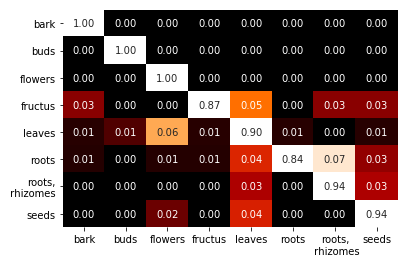

In [15]:

results_dirname = '../results/'
model_filename_base = 'parts_model_td_snn_'
results_filename = 'rank='+str(rank_mz)+model_filename_base+'+CCA.npz'
df = np.load(results_dirname+results_filename)
accuracies = df['accuracies']
f1s = df['f1s']
cms = df['confusion_matrices']


medAcc = np.median(accuracies, axis=0)
medF1 = np.median(f1s, axis=0)
medCMs = np.median(cms, axis=0)

print 'Median accuracy: train=%.4f test=%.4f test2=%.4f' % (medAcc[0], medAcc[1], medAcc[2])
print 'Median F1: train=%.4f test=%.4f test2=%.4f' % (medF1[0], medF1[1], medF1[2])
clsnms = ['bark', 'buds', 'flowers', 'fructus', 'leaves', 'roots', 'roots,\n rhizomes', 'seeds']
df = pd.DataFrame(medCMs, columns=clsnms)
df['names'] = clsnms
df = df.set_index('names')
medCMs /= np.sum(medCMs, axis=1, keepdims=True)
msk1 = medCMs.copy()
np.fill_diagonal(msk1, 0.)
sns.heatmap(
    medCMs, annot=True, vmin=msk1.min(), vmax=1.05*msk1.max(),
    xticklabels=clsnms, yticklabels=clsnms, cbar=None,
    fmt='.2f', cmap='gist_heat', #mask=np.eye(len(clsnms))
)
plt.savefig('parts_sntd.pdf')